# Transfer learning VGG16
In this Jupyter Notebook appears the code used for the classification of images witha pretrained model VGG16 plus a fully connected layer, which is going to be trained.
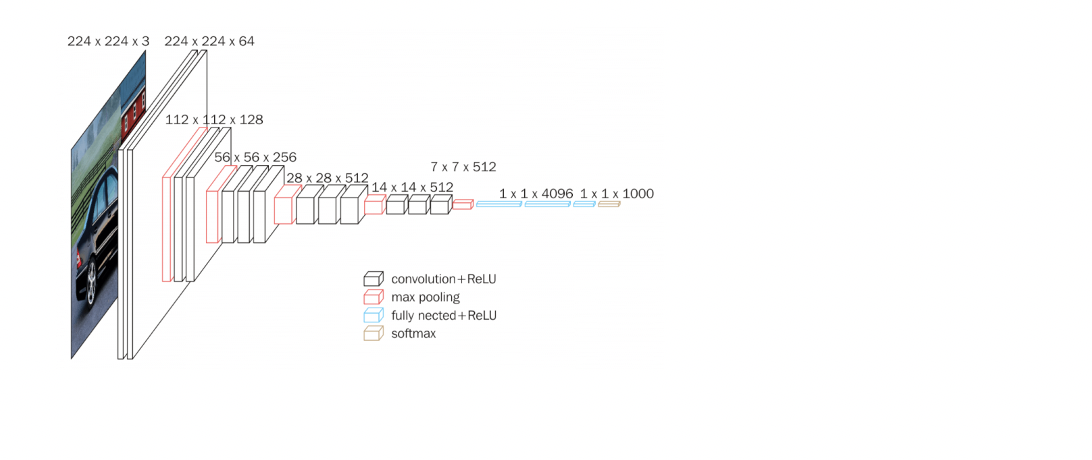

Other of the trainings was using Transfer Learning with VGG16. The VGG16 classify 1000 classes, however we only need to classify 3. For that purpose, we have to adjust our model and in the FC layer it is only needed one hidden layer of size 1x1x1024. It has also been tested to introduce pre-processing of the VGG16 images to standardize them according to how the model weights have been trained.
In addition, as the images to classify are totally different to the pretrained model, so it is needed to use fine tuning to freeze and not retrain again the weights of the convolutional block. 




The best result was achieved with data augmentation, using the VGG16 model. With a batch size of 10, a depth of 6, 74% accuracy was obtained, which is a big improvement compared to the previous model. Learning rate, batch size or even fully connected layers size are parameter that could be tuned to get better results.




In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import tensorflow as tf
import numpy as np
import pandas as pd

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input 

apply_data_augmentation = True

# Create training ImageDataGenerator object and setting a validation split
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False, #doesnt make sense for this problem
                                        fill_mode='constant',
                                        validation_split=0.2, #take 20% of the training data for validation
                                        cval=0,
                                        rescale=1./255, 
                                        preprocessing_function=preprocess_input #preprocessing image to normalize as VGG16 is trained
                                        )
else:
    train_data_gen = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.2,
                                         preprocessing_function=preprocess_input)


# Only test ImageDataGenerator objects because validation is done with part of trainning data

test_data_gen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/My Drive/MaskDataset.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: MaskDataset/training/17141.jpg  
  inflating: __MACOSX/MaskDataset/training/._17141.jpg  
  inflating: MaskDataset/training/11530.jpg  
  inflating: __MACOSX/MaskDataset/training/._11530.jpg  
  inflating: MaskDataset/training/15756.jpg  
  inflating: __MACOSX/MaskDataset/training/._15756.jpg  
  inflating: MaskDataset/training/14448.jpg  
  inflating: __MACOSX/MaskDataset/training/._14448.jpg  
  inflating: MaskDataset/training/12987.jpg  
  inflating: __MACOSX/MaskDataset/training/._12987.jpg  
  inflating: MaskDataset/training/13441.jpg  
  inflating: __MACOSX/MaskDataset/training/._13441.jpg  
  inflating: MaskDataset/training/15030.jpg  
  inflating: __MACOSX/MaskDataset/training/._15030.jpg  
  inflating: MaskDataset/training/16539.jpg  
  inflating: __MACOSX/MaskDataset/training/._16539.jpg  
  inflating: MaskDataset/training/11256.jpg  
  inflating: __MACOSX/MaskDataset/training/._11256.jpg  
  inflating:

In [6]:
#Create dir for each classification label if not exist
dataset_dir = os.path.join(cwd, 'MaskDataset')
old_dir = os.path.join(dataset_dir, 'training')
sorted_dataset_dir = os.path.join(dataset_dir, 'sorted_dataset')
if not os.path.exists(sorted_dataset_dir):
    os.makedirs(sorted_dataset_dir)
class0 = os.path.join(sorted_dataset_dir, '0/')
if not os.path.exists(class0):
    os.makedirs(class0)
class1 = os.path.join(sorted_dataset_dir, '1/')
if not os.path.exists(class1):
    os.makedirs(class1)
class2 = os.path.join(sorted_dataset_dir, '2/')  
if not os.path.exists(class2):
    os.makedirs(class2)  
test_dir = os.path.join(dataset_dir, 'test/')

In [7]:
#Classify the training data dependind the label is set in train_gt.json

data = pd.read_json(dataset_dir+'/train_gt.json',orient='index')

for d in data.iloc:
    if d[0]==0:
        os.popen('cp "'+old_dir+'/'+d.name+'" "'+class0+d.name+'"') 
    elif d[0]==1:
        os.popen('cp "'+old_dir+'/'+d.name+'" "'+class1+d.name+'"') 
    else:
        os.popen('cp "'+old_dir+'/'+d.name+'" "'+class2+d.name+'"') 

In [8]:
# Create generators to read images from dataset directory, in this case from the data already sorted 


# Batch size
bs = 100

# img shape
img_h = 256
img_w = 256

# Number of clases: 0,1,2
num_classes=3

# Training
training_dir = os.path.join(dataset_dir, 'sorted_dataset')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs,
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               subset="training",
                                               shuffle=True,
                                               seed=SEED)  

# Validation
validation_dir = os.path.join(dataset_dir, 'sorted_dataset')
valid_gen = train_data_gen.flow_from_directory(validation_dir,
                                               batch_size=bs, 
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               subset="validation", #takes the 20% of the training data 
                                               shuffle=False,
                                               seed=SEED)

# Test
test_dir = os.path.join(dataset_dir, 'test/')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             batch_size=bs, 
                                             color_mode='rgb',
                                             class_mode='categorical',
                                             shuffle=False,
                                             seed=SEED)

Found 4492 images belonging to 3 classes.
Found 1122 images belonging to 3 classes.
Found 0 images belonging to 0 classes.


In [9]:
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
train_dataset = train_dataset.repeat()

# Validation
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
valid_dataset = valid_dataset.repeat()

# Test
test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
test_dataset = test_dataset.repeat()

In [10]:
# Load the model VGG16 Model

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [11]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [12]:
# Create Model and fine tuning

finetuning = True  #If the model is not similar to the pretreined Convolutional Block 

if finetuning:
    freeze_until = 16 # layer from which we want to fine-tune 
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False
#trainable layers for classification,FC   
model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights;

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 48,273,219
Trainable params: 38,278,147
Non-trainable params: 9,995,072
_________________________________________________________________


In [13]:
# Optimization params

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = ['accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [14]:
#Callbaks
import os
from datetime import datetime


cwd = '/content/drive/My Drive/Keras3'

exps_dir = os.path.join(cwd, 'transfer_learning_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []


# Visualize Learning on Tensorboard
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)
callbacks.append(tb_callback)

# Early Stopping

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    callbacks.append(es_callback)


In [ ]:
#Model fitting
model.fit(x=train_dataset,
          epochs=10,  # set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)


Epoch 1/10
45/45 [==============================] - 4035s 90s/step - loss: 1.1057 - accuracy: 0.5040 - val_loss: 0.6494 - val_accuracy: 0.6747
Epoch 2/10
45/45 [==============================] - 4028s 90s/step - loss: 0.6007 - accuracy: 0.7213 - val_loss: 0.5734 - val_accuracy: 0.7282
Epoch 3/10
 6/45 [===>..........................] - ETA: 40:30 - loss: 0.5181 - accuracy: 0.7650

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Keras3/transfer_learning_experiments/

In [ ]:
#Create folder to download the results in my drive
results_dir= os.path.join('/content/drive/My Drive/Resultados/', 'results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [ ]:
import os
from datetime import datetime

#Function to save the results in a csv with the data and time of creation

def create_csv(results, results_dir='/content/drive/My Drive/Resultados/results/'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
# Making the prediction for the test dataset and save it in a csv

from PIL import Image

#Upload the test images names
image_filenames = next(os.walk('/content/MaskDataset/test'))[2]

results = {}
#Loop to predict each image label
for image_name in image_filenames:
  img = Image.open('/content/MaskDataset/test/'+image_name).convert('RGB')
  img=img.resize(size=(img_w,img_h))
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array= img_array/255
  # Prediction for each image 
  prediction = model.predict(img_array, batch_size=1, verbose=0, 
                             steps=None, callbacks=None)[0]
# Convert predictions classes to one hot vectors 
  pred_classes = np.argmax(prediction) 

# Save the prediction for each image name
  results[image_name] = pred_classes


create_csv(results)

#END
